In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

rng = np.random.default_rng(42)

Load the data

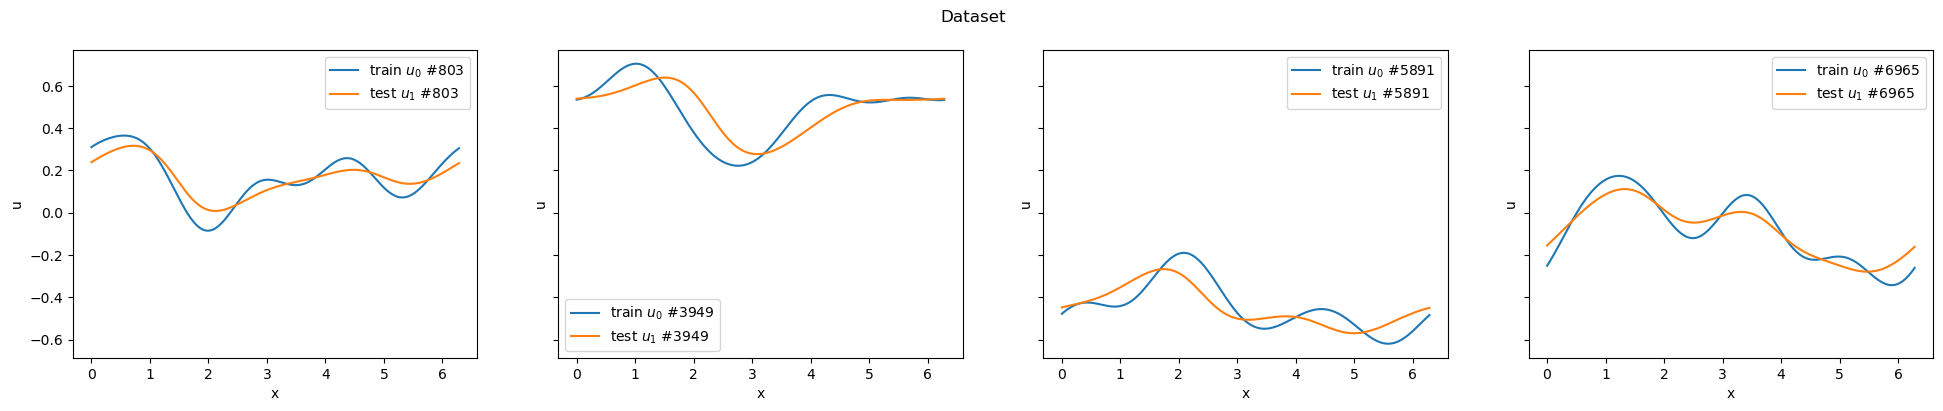

In [9]:
train_u0, train_u1 = np.load("dataset/train.npy")
test_u0, test_u1 = np.load("dataset/test.npy")
x_space = np.linspace(0, 2*np.pi, train_u0.shape[1])

n_to_plot = 4
indices = rng.integers(train_u0.shape[0], size=n_to_plot)
fig, axes = plt.subplots(1, n_to_plot, figsize=(6*n_to_plot, 4),
                         sharex=True, sharey=True)
for ax, idx in zip(axes, sorted(indices)):
    ax.plot(x_space, train_u0[idx], label=fr"train $u_0$ #{idx}")
    ax.plot(x_space, train_u1[idx], label=fr"test $u_1$ #{idx}")
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.legend()

fig.suptitle("Dataset");

Train the model

In [10]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim, output_dim, seed=42):
        super(SimpleModel, self).__init__()
        torch.manual_seed(seed)

        self.model = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.Tanh(),
            nn.Linear(4096, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# Conversione in tensori PyTorch (tipo float32)
train_u0_tensor = torch.tensor(train_u0, dtype=torch.float32)
train_u1_tensor = torch.tensor(train_u1, dtype=torch.float32)
test_u0_tensor = torch.tensor(test_u0, dtype=torch.float32)
test_u1_tensor = torch.tensor(test_u1, dtype=torch.float32)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

# Dataset e DataLoader
train_dataset = TensorDataset(train_u0_tensor, train_u1_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Definisci modello
model = SimpleModel(input_dim=256, output_dim=256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-10)
loss_fn = nn.MSELoss()

# Training loop
epochs = 100
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = loss_fn(predictions, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

Epoch 1/100, Loss: 1.137966
Epoch 2/100, Loss: 0.558524
Epoch 3/100, Loss: 0.508568
Epoch 4/100, Loss: 0.397512
Epoch 5/100, Loss: 0.240004
Epoch 6/100, Loss: 0.175846
Epoch 7/100, Loss: 0.149238
Epoch 8/100, Loss: 0.104526
Epoch 9/100, Loss: 0.093754
Epoch 10/100, Loss: 0.083946
Epoch 11/100, Loss: 0.072882
Epoch 12/100, Loss: 0.064214
Epoch 13/100, Loss: 0.074211
Epoch 14/100, Loss: 0.059766
Epoch 15/100, Loss: 0.069847
Epoch 16/100, Loss: 0.053530
Epoch 17/100, Loss: 0.048354
Epoch 18/100, Loss: 0.059194
Epoch 19/100, Loss: 0.040673
Epoch 20/100, Loss: 0.044736
Epoch 21/100, Loss: 0.052635
Epoch 22/100, Loss: 0.048096
Epoch 23/100, Loss: 0.041149
Epoch 24/100, Loss: 0.043047
Epoch 25/100, Loss: 11.310675
Epoch 26/100, Loss: 1.955365
Epoch 27/100, Loss: 0.069248
Epoch 28/100, Loss: 0.051808
Epoch 29/100, Loss: 0.044178
Epoch 30/100, Loss: 0.035577
Epoch 31/100, Loss: 0.033758
Epoch 32/100, Loss: 0.032548
Epoch 33/100, Loss: 0.027307
Epoch 34/100, Loss: 0.025654
Epoch 35/100, Loss: 0.

In [22]:
def compute_rel_l2_error(true, prediction):
    diff_norm = torch.norm(true - prediction, dim=1)
    true_norm = torch.norm(true, dim=1)
    return diff_norm / true_norm


model.eval()
with torch.no_grad():
    test_predictions = model(test_u0_tensor)
    test_errors = compute_rel_l2_error(test_u1_tensor, test_predictions)

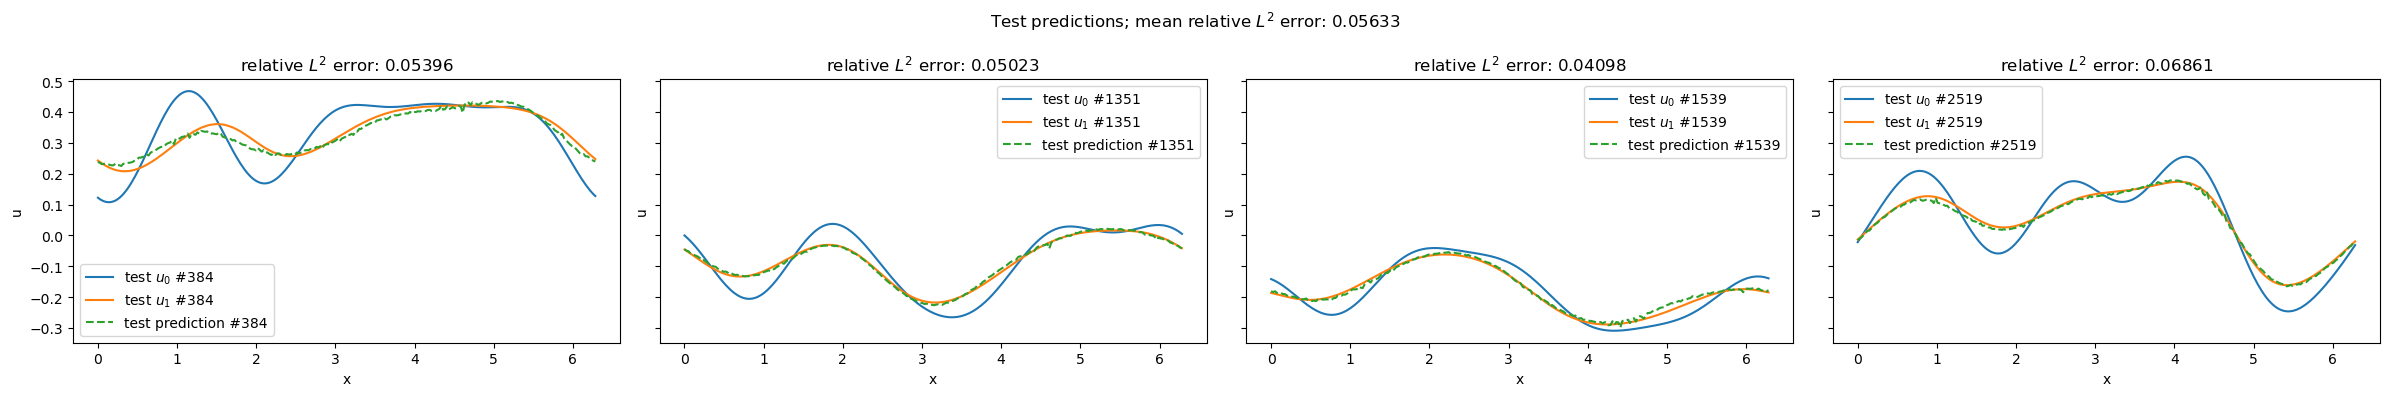

In [ ]:
n_to_plot = 4
indices = rng.integers(test_u0.shape[0], size=n_to_plot)
fig, axes = plt.subplots(1, n_to_plot, figsize=(6*n_to_plot, 4),
                         sharex=True, sharey=True)
for ax, idx in zip(axes, sorted(indices)):
    ax.plot(x_space, test_u0[idx], label=f"test $u_0$ #{idx}")
    ax.plot(x_space, test_u1[idx], label=f"test $u_1$ #{idx}")
    ax.plot(x_space, test_predictions[idx], linestyle="--", label=f"test prediction #{idx}")
    ax.set_title(fr"relative $L^2$ error: {test_errors[idx]:.5f}")
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.legend()

fig.suptitle("Test predictions; " + fr"mean relative $L^2$ error: {test_errors.mean():.5f}");
fig.tight_layout()
